Spike trains are generated using univariate, self‐exciting Hawkes point process with an exponential kernel, using Ogata’s thinning algorithm. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from datetime import datetime

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import func_single_exp_monkey, fit_single_exp
from calculate_acf import acf_sttc
from spike_train_utils import bin_spike_train_fixed_len
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic_data\\results\\'
fig_folder = project_folder_path + 'results\\synthetic_data\\fig_drafts_paper_reduce\\'

In [30]:
save_fig = True

#### Load spike trains

In [ ]:
# rate_hz     = 3.5     # target firing rate (Hz)
# tau_ms      = 100.0    # desired autocorr time constant (ms)
# alpha       = 0.3      # self‐excitation weight (must be <1)

In [3]:
all_spike_trains = np.load(dataset_folder + 'spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_1000.npy', allow_pickle=True)
print(f'n spike trains {len(all_spike_trains)}, len {all_spike_trains[0][-1]/1000}')

duration_ms = 600 * 1000
target_fr_hz = 3.5
target_tau_ms = 100

fs = 1000

n spike trains 1000, len 599.4657698736828


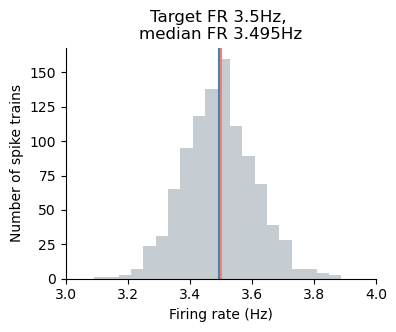

In [4]:
# Compute firing rates (Hz)
duration_s = duration_ms / 1000.0
rates = [len(train) / duration_s for train in all_spike_trains]

fig, axes = plt.subplots(1,1, figsize=(4,3))

axes.hist(rates, bins=20, color='slategray', alpha=0.4)
axes.axvline(x=target_fr_hz, color='salmon')
axes.axvline(x=np.median(rates), color='steelblue')
axes.set_xlabel('Firing rate (Hz)')
axes.set_ylabel('Number of spike trains')
axes.set_title(f'Target FR {target_fr_hz}Hz, \nmedian FR {np.round(np.median(rates),4)}Hz')
axes.set_xlim([3,4])

sns.despine()

#### Calculate acf and taus

##### ACFs

In [5]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

bin_size = int(50 * (fs / 1000))
sttc_dt = int(25 * (fs / 1000))

calc_acf_full = True
calc_isttc_full = True

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [ ]:
all_spike_trains_binned_l = []
for i in range(len(all_spike_trains)):
    binned_spike_train = bin_spike_train_fixed_len([int(spike) for spike in all_spike_trains[i]],
                                                   bin_size, fs, duration_ms,
                                                   verbose_=False)
    all_spike_trains_binned_l.append(binned_spike_train)

In [ ]:
if calc_acf_full:
    acf_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains_binned_l):
        if unit_idx % 100 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_binned_acf = acf(unit, nlags=n_lags)
        acf_full_l.append(spike_train_binned_acf)
    
    acf_full_df = pd.DataFrame(np.array(acf_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_full_df.isnull().any().any()))
    acf_full_df.head(3)
    
    # acf_full_df.to_pickle(dataset_folder + 'cut_30min\\binned\\acf\\acf_full_50ms_20lags_df.pkl')

In [ ]:
if calc_isttc_full:
    acf_isttc_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains):
        if unit_idx % 100 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_int = np.asarray([int(spike) for spike in unit])
        spike_train_acf = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, duration_ms, verbose_=False)
        acf_isttc_full_l.append(spike_train_acf)
    
    acf_isttc_full_df = pd.DataFrame(np.array(acf_isttc_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_isttc_full_df.isnull().any().any()))
    acf_isttc_full_df.head(3)

##### Taus

In [ ]:
calc_taus = True

In [ ]:
if calc_taus:
    acf_full_2d = acf_full_df[acf_cols].values
    print(f'acf_2d shape {acf_full_2d.shape}')
    acf_full_unit_ids = acf_full_df.index.values
    print(f'acf_full_unit_ids shape {acf_full_unit_ids.shape}')
    
    acf_full_dict = {}
    for unit_id_idx, unit_id in enumerate(acf_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(acf_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        acf_full_dict[unit_id] = {'taus': taus,
                                  'acf': acf_full_2d[unit_id_idx,:]}

In [ ]:
if calc_taus:
    isttc_full_2d = acf_isttc_full_df[acf_cols].values
    print(f'isttc_full_2d shape {isttc_full_2d.shape}')
    isttc_full_unit_ids = acf_isttc_full_df.index.values
    print(f'isttc_full_unit_ids shape {isttc_full_unit_ids.shape}')
    
    isttc_full_dict = {}
    for unit_id_idx, unit_id in enumerate(isttc_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(isttc_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(isttc_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        isttc_full_dict[unit_id] = {'taus': taus,
                                    'acf': isttc_full_2d[unit_id_idx,:]}

In [ ]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict_25dt.pkl', "wb") as f:
    pickle.dump(isttc_full_dict, f)

In [ ]:
with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "wb") as f:
    pickle.dump(acf_full_dict, f)

In [7]:
with open(results_folder + 'acf_isttc_full_50ms_20lags_dict_25dt.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_20lags_dict_25dt.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

In [9]:
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 1000
len acf_full_dict 1000
len pearsonr_trial_avg_dict 1000
len sttc_trial_avg_dict 1000
len sttc_trial_concat_dict 1000


##### Make summary dfs

In [10]:
def get_trials_plot_df(trial_dict_, acf_cols_, method_, n_iteration=None):
    unit_id_l, trial_acf_l, taus_l, fit_r_squared_l, decline_150_250_l = [], [], [], [], []
    for unit_id, unit_data in trial_dict_.items():
        taus = unit_data['taus']  
        acf = unit_data['acf']  

        if n_iteration is not None:
            unit_id_l.append([unit_id])
            trial_acf_l.append(acf[n_iteration[unit_id]])
            taus_l.append(taus[n_iteration[unit_id]]['tau'])
            fit_r_squared_l.append(taus[n_iteration[unit_id]]['fit_r_squared'])
            decline_150_250_l.append(calculate_acf_decline_flag(acf[n_iteration[unit_id]], start_idx=2, end_idx=4))
        else:
            unit_id_l.append([unit_id] * 100)
            trial_acf_l.append(acf)
            taus_l.append([d['tau'] for d in taus])
            fit_r_squared_l.append([d['fit_r_squared'] for d in taus])
            decline_150_250_l.append([calculate_acf_decline_flag(acf, start_idx=2, end_idx=4) for acf in acf])
        
    trial_plot_df = pd.DataFrame(np.vstack(trial_acf_l), columns=acf_cols_)
    trial_plot_df.insert(0, 'unit_id', np.hstack(unit_id_l))
    trial_plot_df.insert(1, 'tau', np.hstack(taus_l))
    trial_plot_df.insert(2, 'fit_r_squared', np.hstack(fit_r_squared_l))
    trial_plot_df.insert(3, 'decline_150_250', np.hstack(decline_150_250_l))
    trial_plot_df.insert(4, 'method', method_)
    
    trial_plot_df.insert(2, 'tau_ms', trial_plot_df['tau'] * 50)

    rows_with_nans_df = trial_plot_df[trial_plot_df.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    print(f'N rows with NaNs {n_rows_with_nan}')
    
    return trial_plot_df

In [11]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [12]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
#acf_full_plot_df = acf_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'

acf_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,2.338126,1.642157,3.034094,0.932187,True,acf_full,116.906290
1,1,1.665427,1.324888,2.005965,0.966912,True,acf_full,83.271337


In [ ]:
acf_full_plot_df.describe()

In [13]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_isttc_full_plot_df = pd.DataFrame(data)
acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['tau_ms'] = acf_isttc_full_plot_df['tau'] * 50
#acf_isttc_full_plot_df = acf_isttc_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_isttc_full_plot_df[acf_isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,2.512025,1.722675,3.301374,0.925774,False,isttc_full,125.601231
1,1,1.539509,1.183404,1.895614,0.958556,True,isttc_full,76.975439


#### Get plot dfs and plot

In [40]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

##### Example plot for panel B

In [14]:
n_trials_impl = 50
random_trials_impl_l = []
for i in range(n_trials_impl):
    random_trials_impl_l.append(random.choices(range(0, 100), k=1000))

In [35]:
# df for example plot
random_trials_impl = random_trials_impl_l[10]

acf_pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, acf_cols[:-1], 'pearsonr_trial_avg', random_trials_impl)
acf_sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, acf_cols[:-1], 'sttc_trial_concat', random_trials_impl)
acf_sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, acf_cols[:-1], 'sttc_trial_avg', random_trials_impl)

tau_concat_one_ex_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_plot_df, acf_sttc_trial_avg_plot_df, acf_sttc_trial_concat_plot_df])
tau_concat_one_ex_df['log_tau'] = np.log10(tau_concat_one_ex_df['tau_ms'])
tau_concat_one_ex_df.reset_index(inplace=True, drop=True)

tau_concat_one_ex_df = tau_concat_one_ex_df[['unit_id', 'tau', 'tau_lower', 
                                             'tau_upper', 'fit_r_squared','decline_150_250', 'method', 'tau_ms','log_tau']].copy()
tau_concat_one_ex_df

N rows with NaNs 2
N rows with NaNs 0
N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,log_tau
0,0,2.338126,1.642157,3.034094,0.932187,True,acf_full,116.906290,2.067838
1,1,1.665427,1.324888,2.005965,0.966912,True,acf_full,83.271337,1.920496
2,2,1.777164,1.285633,2.268695,0.940679,True,acf_full,88.858193,1.948697
3,3,2.204418,1.466230,2.942607,0.915245,True,acf_full,110.220913,2.042264
4,4,2.382246,1.502596,3.261896,0.899545,True,acf_full,119.112301,2.075957
...,...,...,...,...,...,...,...,...,...
4995,995,9780.256831,NaN,NaN,0.742493,True,sttc_trial_concat,489012.841527,5.689320
4996,996,0.535094,NaN,NaN,0.244682,True,sttc_trial_concat,26.754707,1.427400
4997,997,2.268014,NaN,NaN,0.164929,True,sttc_trial_concat,113.400687,2.054616
4998,998,0.104580,NaN,NaN,0.003484,True,sttc_trial_concat,5.229002,0.718419


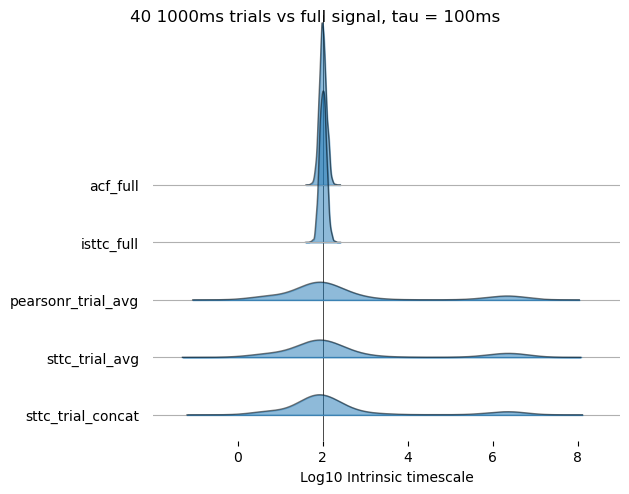

In [36]:
fig, axes = joypy.joyplot(data=tau_concat_one_ex_df,
    by='method',
    column='log_tau',
    range_style='own',
    grid="y",
    kind='kde',
    overlap=2,
    alpha=0.5,
    linewidth=1,
    x_range=[-2,9]
)

axes[-1].axvline(x=2, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('40 1000ms trials vs full signal, tau = 100ms')

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods.svg' , bbox_inches='tight')

In [74]:
# your long‐form DataFrame
df = tau_concat_one_ex_df.copy()

# define your intervals (you listed four)
intervals = {
    '0–200':   (0,   200),
    '25–175':  (25,  175),
    '50–150':  (50,  150),
    '75–125':  (75,  125),
}

# build a per-method percentage table
rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

percent_df = pd.DataFrame(rows).set_index('method')
percent_df

,0–200,25–175,50–150,75–125
method,,,,
acf_full,100.0,99.8,98.5,81.4
isttc_full,100.0,99.7,98.2,81.2
pearsonr_trial_avg,70.0,53.5,36.5,18.3
sttc_trial_avg,69.5,53.4,37.2,19.5
sttc_trial_concat,73.9,58.5,42.0,20.0


In [75]:
percent_df = percent_df.reset_index()
percent_long = percent_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
percent_long

,method,interval,percentage
0,acf_full,0–200,100.0
1,isttc_full,0–200,100.0
2,pearsonr_trial_avg,0–200,70.0
3,sttc_trial_avg,0–200,69.5
4,sttc_trial_concat,0–200,73.9
5,acf_full,25–175,99.8
6,isttc_full,25–175,99.7
7,pearsonr_trial_avg,25–175,53.5
8,sttc_trial_avg,25–175,53.4
9,sttc_trial_concat,25–175,58.5


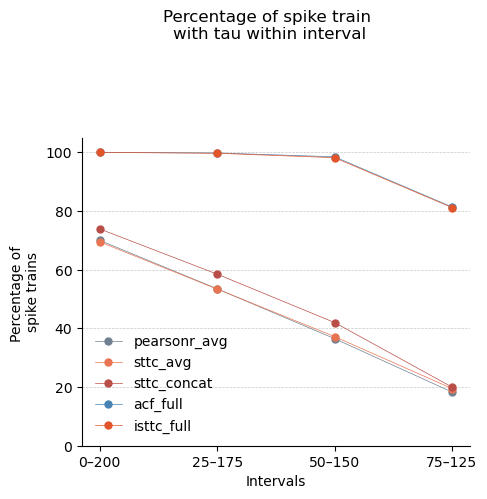

In [81]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, percent_long)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_one_trials_impl.svg' , bbox_inches='tight')

In [56]:
tau_concat_one_ex_df.groupby(by='method').median()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,log_tau
method,,,,,,,,
acf_full,499.5,1.985879,1.453620,2.515793,0.944567,1.0,99.293968,1.996923
isttc_full,499.5,2.012737,1.468834,2.553402,0.943415,1.0,100.636835,2.002757
pearsonr_trial_avg,499.5,1.864504,NaN,NaN,0.254792,1.0,93.225214,1.969533
sttc_trial_avg,499.5,1.887420,NaN,NaN,0.251762,1.0,94.370977,1.974838
sttc_trial_concat,499.5,1.835872,NaN,NaN,0.253674,1.0,91.793580,1.962812


In [58]:
gt = 100.0

# Compute RMSE per method
rmse_per_method = (
    tau_concat_one_ex_df
    .groupby('method')['tau_ms']
    .apply(lambda x: np.sqrt(np.mean((x - gt)**2)))
    .reset_index(name='rmse')
)

print(rmse_per_method)

               method          rmse
0            acf_full  1.987558e+01
1          isttc_full  1.981053e+01
2  pearsonr_trial_avg  9.628975e+05
3      sttc_trial_avg  1.050487e+06
4   sttc_trial_concat  8.683990e+05


#### Plot

In [60]:
dfs = []

for idx, random_trials_impl in enumerate(random_trials_impl_l):
    # build each method’s DataFrame for this particular impl
    df_p = get_trials_plot_df(pearsonr_trial_avg_dict,
                              acf_cols[:-1],
                              'pearsonr_trial_avg',
                              random_trials_impl)
    df_sa = get_trials_plot_df(sttc_trial_avg_dict,
                               acf_cols[:-1],
                               'sttc_trial_avg',
                               random_trials_impl)
    df_sc = get_trials_plot_df(sttc_trial_concat_dict,
                               acf_cols[:-1],
                               'sttc_trial_concat',
                               random_trials_impl)
    
    # also include the “full” methods (assuming these don’t depend on the random_trials_impl)
    df_full = acf_full_plot_df.copy()
    df_isttc = acf_isttc_full_plot_df.copy()
    
    # concatenate all methods for this one example
    one_ex = pd.concat([df_full,
                        df_isttc,
                        df_p,
                        df_sa,
                        df_sc],
                       ignore_index=True)
    
    # compute log_tau and reorder columns
    one_ex['log_tau'] = np.log10(one_ex['tau_ms'])
    one_ex = one_ex[['unit_id', 'tau', 'tau_lower', 'tau_upper',
                     'fit_r_squared', 'decline_150_250',
                     'method', 'tau_ms', 'log_tau']]
    
    # tag with which random_trials_impl index this came from
    one_ex['random_trials_impl_idx'] = idx
    
    dfs.append(one_ex)

# merge them all into one long DataFrame
tau_concat_all_ex_df = pd.concat(dfs, ignore_index=True)

# quick sanity check
print(tau_concat_all_ex_df.shape)
print(tau_concat_all_ex_df['random_trials_impl_idx'].nunique(), 'unique impls')

N rows with NaNs 1
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 5
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 2
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 4
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 6
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 8
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 2
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 6
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 5
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 4
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 2
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 5
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 4
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 7
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 5
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 5
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 7
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 2
N rows with 

In [61]:
tau_concat_all_ex_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,log_tau,random_trials_impl_idx
0,0,2.338126,1.642157,3.034094,0.932187,True,acf_full,116.906290,2.067838,0
1,1,1.665427,1.324888,2.005965,0.966912,True,acf_full,83.271337,1.920496,0
2,2,1.777164,1.285633,2.268695,0.940679,True,acf_full,88.858193,1.948697,0
3,3,2.204418,1.466230,2.942607,0.915245,True,acf_full,110.220913,2.042264,0
4,4,2.382246,1.502596,3.261896,0.899545,True,acf_full,119.112301,2.075957,0
...,...,...,...,...,...,...,...,...,...,...
249995,995,2.598542,NaN,NaN,0.402638,True,sttc_trial_concat,129.927084,2.113700,49
249996,996,0.802987,NaN,NaN,0.174757,True,sttc_trial_concat,40.149339,1.603678,49
249997,997,0.091826,NaN,NaN,0.123473,False,sttc_trial_concat,4.591294,0.661935,49
249998,998,3.947655,NaN,NaN,0.243209,False,sttc_trial_concat,197.382725,2.295309,49


In [64]:
# your big long df
df = tau_concat_all_ex_df.copy()

# define the intervals you care about
intervals = {
    '0–200':  (0,   200),
    '25–175': (25,  175),
    '50–150': (50,  150),
    '75–125': (75,  125),
}

rows = []
# loop over each resampling impl and each method
for idx, df_idx in df.groupby('random_trials_impl_idx'):
    total_idx = len(df_idx)
    for method, df_m in df_idx.groupby('method'):
        total_m = len(df_m)
        for name, (lo, hi) in intervals.items():
            cnt = df_m['tau_ms'].between(lo, hi).sum()
            rows.append({
                'random_trials_impl_idx': idx,
                'method': method,
                'interval': name,
                'percentage': cnt/total_m * 100
            })

percent_long = pd.DataFrame(rows)
percent_long

,random_trials_impl_idx,method,interval,percentage
0,0,acf_full,0–200,100.0
1,0,acf_full,25–175,99.8
2,0,acf_full,50–150,98.5
3,0,acf_full,75–125,81.4
4,0,isttc_full,0–200,100.0
...,...,...,...,...
995,49,sttc_trial_avg,75–125,17.9
996,49,sttc_trial_concat,0–200,72.6
997,49,sttc_trial_concat,25–175,56.7
998,49,sttc_trial_concat,50–150,38.8


In [70]:
summary_df = (
    percent_long
    .groupby(['method','interval'])['percentage']
    .agg(
        median = 'mean',
        lower_95 = lambda x: x.quantile(0.025),
        upper_95 = lambda x: x.quantile(0.975)
    )
    .reset_index()
)
summary_df = summary_df.rename(columns={'median': 'percentage'})
summary_df

,method,interval,percentage,lower_95,upper_95
0,acf_full,0–200,100.000,100.0000,100.0000
1,acf_full,25–175,99.800,99.8000,99.8000
2,acf_full,50–150,98.500,98.5000,98.5000
3,acf_full,75–125,81.400,81.4000,81.4000
4,isttc_full,0–200,100.000,100.0000,100.0000
5,isttc_full,25–175,99.700,99.7000,99.7000
6,isttc_full,50–150,98.200,98.2000,98.2000
7,isttc_full,75–125,81.200,81.2000,81.2000
8,pearsonr_trial_avg,0–200,69.656,67.5450,72.0550
9,pearsonr_trial_avg,25–175,53.450,50.6900,56.3775


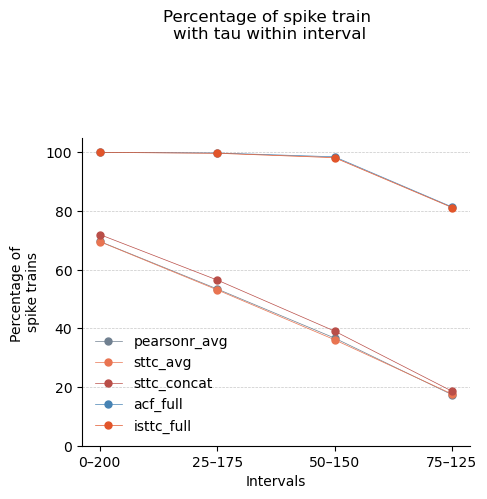

In [83]:
fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, summary_df)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_50_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_50_trials_impl.svg' , bbox_inches='tight')

##### t

In [92]:
acf_pearsontr_trial_avg_df = get_trials_plot_df(pearsonr_trial_avg_dict, acf_cols[:-1], 'pearsonr_trial_avg')
acf_sttc_trial_concat_df = get_trials_plot_df(sttc_trial_concat_dict, acf_cols[:-1], 'sttc_trial_concat')
acf_sttc_trial_avg_df = get_trials_plot_df(sttc_trial_avg_dict, acf_cols[:-1], 'sttc_trial_avg')

acf_pearsontr_trial_avg_df_med = acf_pearsontr_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_concat_df_med = acf_sttc_trial_concat_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_avg_df_med = acf_sttc_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()

tau_concat_avg_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_df_med, acf_sttc_trial_concat_df_med, acf_sttc_trial_avg_df_med])
tau_concat_avg_df['log_tau'] = np.log10(tau_concat_avg_df['tau_ms'])
tau_concat_avg_df.reset_index(inplace=True, drop=True)

tau_concat_avg_df = tau_concat_avg_df[['unit_id', 'method', 'tau_ms','log_tau']].copy()
tau_concat_avg_df

N rows with NaNs 362
N rows with NaNs 0
N rows with NaNs 0


,unit_id,method,tau_ms,log_tau
0,0,acf_full,116.906290,2.067838
1,1,acf_full,83.271337,1.920496
2,2,acf_full,88.858193,1.948697
3,3,acf_full,110.220913,2.042264
4,4,acf_full,119.112301,2.075957
...,...,...,...,...
4995,995,sttc_trial_avg,102.247867,2.009654
4996,996,sttc_trial_avg,129.527551,2.112362
4997,997,sttc_trial_avg,78.994635,1.897598
4998,998,sttc_trial_avg,108.192653,2.034198


In [93]:
# your long‐form DataFrame
df = tau_concat_avg_df.copy()

# define your intervals (you listed four)
intervals = {
    '0–200':   (0,   200),
    '25–175':  (25,  175),
    '50–150':  (50,  150),
    '75–125':  (75,  125),
}

# build a per-method percentage table
rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

percent_df = pd.DataFrame(rows).set_index('method')
percent_df

,0–200,25–175,50–150,75–125
method,,,,
acf_full,100.0,99.8,98.5,81.4
isttc_full,100.0,99.7,98.2,81.2
pearsonr_trial_avg,99.9,99.5,96.6,75.1
sttc_trial_avg,99.7,99.1,96.4,74.1
sttc_trial_concat,100.0,99.6,97.1,74.3


In [94]:
percent_df = percent_df.reset_index()
percent_long = percent_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
percent_long

,method,interval,percentage
0,acf_full,0–200,100.0
1,isttc_full,0–200,100.0
2,pearsonr_trial_avg,0–200,99.9
3,sttc_trial_avg,0–200,99.7
4,sttc_trial_concat,0–200,100.0
5,acf_full,25–175,99.8
6,isttc_full,25–175,99.7
7,pearsonr_trial_avg,25–175,99.5
8,sttc_trial_avg,25–175,99.1
9,sttc_trial_concat,25–175,99.6


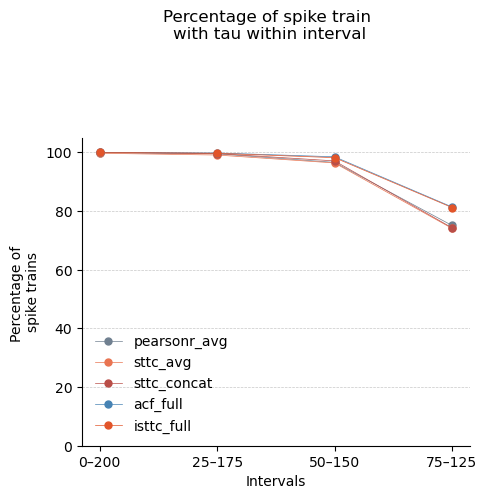

In [95]:
fig, axes = plt.subplots(1,1,figsize=(5,4))

plot_one_threshold(axes, percent_long)


# ax.set_xscale('log')
# ax.set_xticks(m_iterations_x_axes)
# ax.set_xticklabels(m_iterations_x_axes, rotation=45, fontsize=8)
axes.set_ylabel('Percentage of \nspike trains')
axes.set_xlabel('Intervals')
axes.set_ylim([0, 105])
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
sns.despine(ax=axes)
axes.legend(frameon=False)

fig.suptitle(f'Percentage of spike train \nwith tau within interval', y=1.20)

if save_fig:
    plt.savefig(fig_folder + 'taus_in_intervals_med_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_in_intervals_med_trials_impl.svg' , bbox_inches='tight')

### ZZZ

In [ ]:
tau_concat_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_plot_df, acf_sttc_trial_avg_plot_df, acf_sttc_trial_concat_plot_df])
tau_concat_df.reset_index(inplace=True, drop=True)
tau_concat_df['ground_truth_diff'] = tau_concat_df['tau_ms'] - target_tau_ms
tau_concat_df['ground_truth_diff_abs'] = np.abs(tau_concat_df['ground_truth_diff'])
tau_concat_df

In [ ]:
tau_concat_df.query('tau_ms < 125 and tau_ms > 25').groupby(by='method', as_index=False).count()

In [ ]:
tau_concat_df.query('tau_ms < 125 and tau_ms > 75').groupby(by='method', as_index=False).median()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='tau_ms', data=tau_concat_df, cut=0,  density_norm='width')
axes.axhline(y=target_tau_ms, color='k')

axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
plt.figure(figsize=(6,4))
sns.ecdfplot(
    data=tau_concat_df,
    x='tau_ms',
    hue='method',
    stat='proportion'
)
plt.xscale('log')
plt.xlabel('tau_ms')
plt.ylabel('Cumulative proportion')
plt.title('ECDF of tau_ms by Method')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.boxenplot(
    data=tau_concat_df,
    y='method',
    x='tau_ms',
    k_depth='tukey',   # more letter‐values
    palette='Set2'
)
plt.xscale('log')
plt.ylabel('tau_ms (log scale)')
plt.xlabel('Method')
plt.title('Boxenplot of τ by Method')
plt.tight_layout()
plt.show()

In [ ]:
# 1) add a log‐τ column
df = tau_concat_df.copy()
df['log_tau'] = np.log10(df['tau_ms'] + 1e-6)

# 2) fix the plotting order so the first two come first
order = ['acf_full',
         'isttc_full',
         'pearsonr_trial_avg',
         'sttc_trial_avg',
         'sttc_trial_concat']

# 3) make the joyplot
fig, axes = joypy.joyplot(
    data      = df,
    by        = 'method',
    column    = 'log_tau',
    kind      = 'kde',
    overlap   = 0.2,           # small global overlap
    range_style = 'own',       # each row gets its *own* x‐range
    fade      = True,
    linewidth = 1,
    figsize   = (6, 5),
    title     = "Ridge Plot of log10(τ) by Method",
)

# 4) yank the first two axes further apart so they *never* overlap
#    (they’re very narrow, so even a little extra space is enough)
for ax in axes[:2]:
    ax.set_ylim(0, ax.get_ylim()[1])  # reset bottom to zero
    ax.margins(y=0.3)                  # add extra headroom

plt.xlabel("log10(τ_ms)")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff', data=tau_concat_df.query('tau_ms < 150 and tau_ms > 50'), cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff_abs', data=tau_concat_df.query('tau_ms < 150 and tau_ms > 50'), cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#axes.set_yscale('log')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15,5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes,
    data=tau_concat_df,
    x='tau_ms',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)

axes.set_xscale('log')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df.query('tau_ms < 200'),
    x='tau_ms',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_pearsontr_trial_avg_plot_df['tau_ms'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_sttc_trial_avg_plot_df['tau_ms'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.axvline(x=target_tau_ms, color='black', lw=0.5)
    #ax.set_xlim([25, 225])
    ax.set_xlabel('Intrinsic timescale (ms)')

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df,
    x='fit_r_squared',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_full_plot_df['fit_r_squared'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
#axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_isttc_full_plot_df['fit_r_squared'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
#axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.set_xlim([0, 1])
    ax.set_xlabel('R-squared')

sns.despine()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.scatterplot(ax=axes[0], x=tau_concat_df.query('method == "pearsonr_trial_avg"')['tau_ms'].values, 
             y=tau_concat_df.query('method == "sttc_trial_concat"')['tau_ms'].values, s=2)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes, lw=0.5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('ACF tau')
axes[0].set_ylabel('iSTTC tau')
axes[0].set_xlim([25, 225])
axes[0].set_ylim([25, 225])
axes[0].axvline(x=target_tau_ms, lw=1, c='salmon')
axes[0].axhline(y=target_tau_ms, lw=1, c='salmon')
axes[0].grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(ax=axes[1], x=tau_concat_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'].values, 
             y=tau_concat_df.query('method == "sttc_trial_concat"')['fit_r_squared'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes, lw=0.5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('ACF R-squared')
axes[1].set_ylabel('iSTTC R-squared')
# axes[1].set_xlim([0.8, 1])
# axes[1].set_ylim([0.8, 1])
axes[1].grid(True, linestyle='--', alpha=0.5)

r_squared_diff = tau_concat_df.query('method == "sttc_trial_concat"')['fit_r_squared'].values - tau_concat_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'].values
n_sttc_better = sum(r_squared_diff > 0)
n_sttc_better_perc = n_sttc_better / len(r_squared_diff) * 100

sns.histplot(ax=axes[2], x=r_squared_diff, stat='probability', bins=20, kde=False, color='steelblue', alpha=0.5)
axes[2].axvline(x=0, lw=1, c='salmon')
axes[2].set_xlabel('STTC R-squared - \nACF R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

#fig.suptitle('sttc vs acf, allen, n_units = ' + str(len(r_squared_diff)), y=1.15)

sns.despine()


#### Tests